In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import odeint
from pyswarm import pso

In [32]:
data = pd.read_csv('covid.csv')
# Convert the 'Date' column to datetime64
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
# Grouping by date and aggregating the number of cured, deaths and confirmed cases
data = data.groupby('Date').agg({'Cured': 'sum', 'Deaths': 'sum', 'Confirmed': 'sum'}).reset_index()
# data_model has data[Cured], data[Deaths] and data[Confirmed] columns from 3rd March 2020 to 28th Nov 2020
data_model = pd.DataFrame(data, columns=['Date','Cured', 'Deaths', 'Confirmed'])
# Calculate the daily cured, deaths and confirmed cases
data_model['daily_cured'] = data_model['Cured'].diff()
data_model['daily_deaths'] = data_model['Deaths'].diff()
data_model['daily_confirmed'] = data_model['Confirmed'].diff()
# Filling the first row with original values
data_model['daily_cured'].fillna(data_model['Cured'], inplace=True)
data_model['daily_deaths'].fillna(data_model['Deaths'], inplace=True)
data_model['daily_confirmed'].fillna(data_model['Confirmed'], inplace=True)

In [33]:
# filter data_model from 3rd March 2020 to 28th Nov 2020
data_sird = data_model[33:304]
# Function to plot the data
def plot_data(data_sird, daily_column, total_column, title):
    fig, ax1 = plt.subplots(figsize=(7, 5))
    # Plot 1
    ax1.bar(data_sird['Date'], data_sird[daily_column], color='blue', alpha=0.5, label= daily_column)
    # Format the x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to show the first day of each month
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))  # Format major ticks as 'dd-mm-yyyy'
    plt.xticks(rotation=45)  # Rotate the x-axis labels
    # Create a second y-axis that shares the same x-axis
    ax2 = ax1.twinx()
    # Plot 2
    ax2.plot(data_sird['Date'], data_sird[total_column], color='red', label= total_column)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(daily_column)
    ax2.set_ylabel(total_column)
    plt.title(title)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
    plt.tight_layout() 
    plt.show()

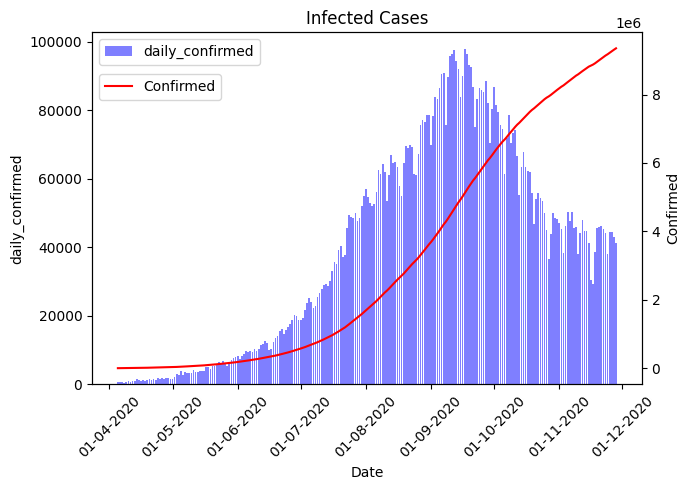

In [34]:
# Confirmed cases
plot_data(data_sird, 'daily_confirmed', 'Confirmed', 'Infected Cases')

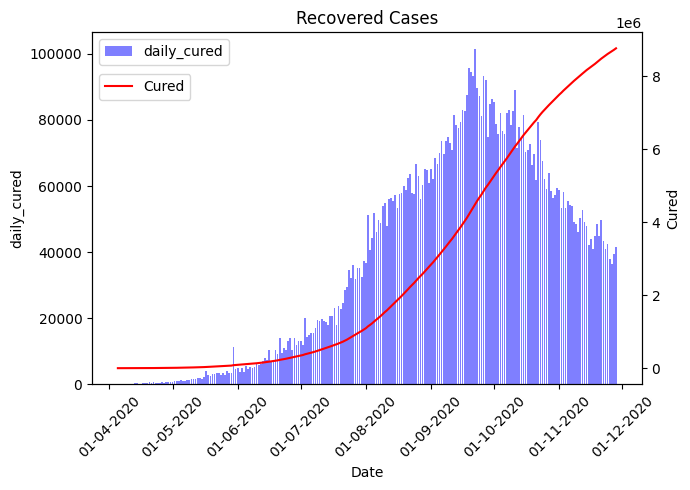

In [35]:
# Recovered cases
plot_data(data_sird, 'daily_cured', 'Cured', 'Recovered Cases')

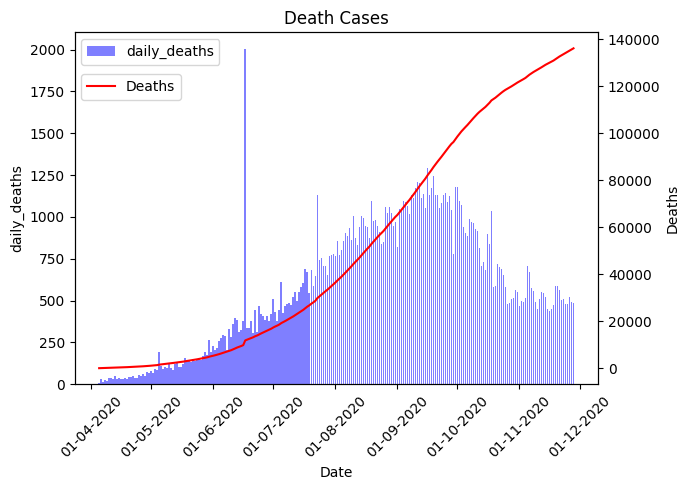

In [36]:
# Deaths
plot_data(data_sird, 'daily_deaths', 'Deaths', 'Death Cases')

In [37]:
# Beta = Infection rate
# Alpha = Recovery rate
# Mu = Death rate
def dY_dT(y, t, beta_0, beta_tau, alpha_0, alpha_1, alpha_tau, mu_0, mu_1, mu_tau, t_lockdown):
    #N = 1.38e9
    if t < t_lockdown:
        beta = beta_0  
        mu = mu_0
    else:
        beta = beta_0*((np.exp(-(t-t_lockdown)/beta_tau))**2)
        mu = mu_1 + mu_0*(np.exp(-(t-t_lockdown)/mu_tau))
    alpha = alpha_0 + (alpha_1/(1 + np.exp(-(t - alpha_tau))))
    S = y[0]
    I = y[1]
    R = y[2]
    dS_dt = -beta*S*(I/N)
    dI_dt = beta*S*(I/N) - alpha*I - mu*I
    dR_dt = alpha*I
    dy_dt = [dS_dt, dI_dt, dR_dt]
    return dy_dt

In [38]:
# Solving differential equation
def solve_ode(init_params, t, I0, R0, S0, N, t_lockdown):
    beta_0, beta_tau, alpha_0, alpha_1, alpha_tau, mu_0, mu_1, mu_tau = init_params
    # Initial conditions
    Y0 = [S0, I0, R0]
    # Solve the ODE
    sol = odeint(dY_dT, Y0, t, args=(beta_0, beta_tau, alpha_0, alpha_1, alpha_tau, mu_0, mu_1, mu_tau, t_lockdown), rtol=1e-6)
    S, I, R = sol[:, 0], sol[:, 1], sol[:, 2]
    D = N - S - I - R
    return t, S, I, R, D

In [39]:
def bisquare_m_estimator(err, k):
    result = (k**2 / 6) * (1 - (1 - (err / k)**2)**3) if np.abs(err) <= k else k**2 / 6
    # Limit the maximum return value to prevent overflow
    return min(result, 1e100)  # or some other large number
def calc_k(exp, calc):
    return 5.38*np.median(np.abs(exp - calc))
def check_finite(J):
    if not np.isfinite(J):
        return 1e100
    else:
        return J
def objective(init_params, t, I_exp, R_exp, D_exp, I0, R0, S0, N, t_lockdown):
    t, S, I, R, D = solve_ode(init_params, t, I0, R0, S0, N, t_lockdown)
    J_i = 0
    J_r = 0
    J_d = 0
    # expected delta I, R, D
    delta_I_exp = np.diff(I_exp) + np.diff(R_exp) + np.diff(D_exp)
    delta_R_exp = np.diff(R_exp)
    delta_D_exp = np.diff(D_exp)
    # Calculated delta I, R, D
    delta_I = np.diff(I) + np.diff(R) + np.diff(D)
    delta_R = np.diff(R)
    delta_D = np.diff(D)
    # Objective function
    k_I = calc_k(delta_I_exp, delta_I)
    k_R = calc_k(delta_R_exp, delta_R)
    k_D = calc_k(delta_D_exp, delta_D)
    for i in range(len(delta_I_exp)):
        err_i = delta_I_exp[i] - delta_I[i]
        err_r = delta_R_exp[i] - delta_R[i]
        err_d = delta_D_exp[i] - delta_D[i]
        J_i += bisquare_m_estimator(err_i, k_I)**2/1e6
        J_i = check_finite(J_i)
        J_r += bisquare_m_estimator(err_r, k_R)**2/1e6
        J_r = check_finite(J_r)
        J_d += bisquare_m_estimator(err_d, k_D)**2/1e6
        J_d = check_finite(J_d)

    J = 20*(J_i) + 50*(J_r) + 100*(J_d)
    return J

In [40]:
# Function to print the results
def print_results(result_x):
  print('beta_0: ', result_x[0])
  print('tau_beta: ', result_x[1])
  print('alpha_0: ', result_x[2])
  print('alpha_1: ', result_x[3])
  print('alpha_tau: ', result_x[4])
  print('mu_0: ', result_x[5])
  print('mu_1: ', result_x[6])
  print('mu_tau: ', result_x[7])

In [41]:
def optimization(init_params, method, args, bounds):
    if method == 'pso':
        lb = [i[0] for i in bounds]
        ub = [i[1] for i in bounds]
        # Run PSO
        result_x, fopt = pso(objective, lb, ub, args=args, swarmsize=100, maxiter=1000, omega=0.5, phip=0.5, phig=0.5)
    else:
        result = minimize(objective, init_params, args=args, bounds=bounds, method=method)
        result_x = result.x
    return result_x

In [42]:
# Data
N = 1.38e9
I_exp = np.array(data_sird['Confirmed'].values)
R_exp = np.array(data_sird['Cured'].values)
D_exp = np.array(data_sird['Deaths'].values)
t = np.linspace(0, len(I_exp), len(I_exp))
# Initial value
I0 = I_exp[0]
R0 = R_exp[0]
D0 = D_exp[0]
S0 = N - I0 - R0 - D0
# parameters
t_lockdown = 22
# beta_0, beta_tau, alpha_0, alpha_1, alpha_tau, mu_0, mu_1, mu_tau
# bounds for above parameters
bounds = [(0, 1), (10, 100), (0.01, 0.1), (0.001, 0.1), (5, 80), (0, 0.5), (0, 0.1), (10, 60)]
args = (t, I_exp, R_exp, D_exp, I0, R0, S0, N, t_lockdown)
init_params = [bounds[i][0] for i in range(len(bounds))]

In [43]:
# Optimal parameters
result_pso = optimization(init_params, 'pso', args, bounds)
result_PS = optimization(init_params, 'Nelder-Mead', args, bounds)
result_G = optimization(init_params, 'L-BFGS-B', args, bounds)
Result_G_PS = optimization(result_G, 'Nelder-Mead', args, bounds)
result_G_PSO = optimization(result_G, 'pso', args, bounds)
Result_G_PS_G = optimization(Result_G_PS, 'L-BFGS-B', args, bounds)
result_G_PSO_G = optimization(result_G_PSO, 'L-BFGS-B', args, bounds)

Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08


In [44]:
# print results as a table, column name = method, rows are the values of each par
import pandas as pd
parameters = ['beta_0', 'tau_beta', 'alpha_0', 'alpha_1', 'alpha_tau', 'mu_0', 'mu_1', 'mu_tau']
# Create a dictionary where the keys are the column names and the values are the optimization results
data = {
    'Parameters': parameters,
    'G': result_G,
    'PS': result_PS,
    'PSO': result_pso,
    'G+PS': Result_G_PS,
    'G+PSO': result_G_PSO,
    'G+PS+G': Result_G_PS_G,
    'G+PSO+G': result_G_PSO_G
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)
df.set_index('Parameters', inplace=True)
# Print the DataFrame
print(df)

                     G         PS        PSO        G+PS       G+PSO  \
Parameters                                                             
beta_0        0.123343   0.125865   0.482263    0.264566    0.284751   
tau_beta    100.000000  99.999530  99.998836  100.000000  100.000000   
alpha_0       0.010000   0.010000   0.025405    0.015394    0.010000   
alpha_1       0.001000   0.001000   0.051286    0.001000    0.001030   
alpha_tau    79.709708  72.080658   5.002127   53.649034   38.054329   
mu_0          0.000007   0.005178   0.500000    0.270942    0.262961   
mu_1          0.000000   0.000000   0.000634    0.003736    0.000000   
mu_tau       10.000000  10.000000  11.635769   10.000000   19.366780   

                G+PS+G     G+PSO+G  
Parameters                          
beta_0        0.264566    0.284751  
tau_beta    100.000000  100.000000  
alpha_0       0.015394    0.010000  
alpha_1       0.001000    0.001030  
alpha_tau    53.649034   38.054329  
mu_0          0.2709

In [45]:
def sird_sol(result, t, I0, R0, S0, N, t_lockdown):
    t, S, I, R, D = solve_ode(result, t, I0, R0, S0, N, t_lockdown)
    return t, S, I, R, D

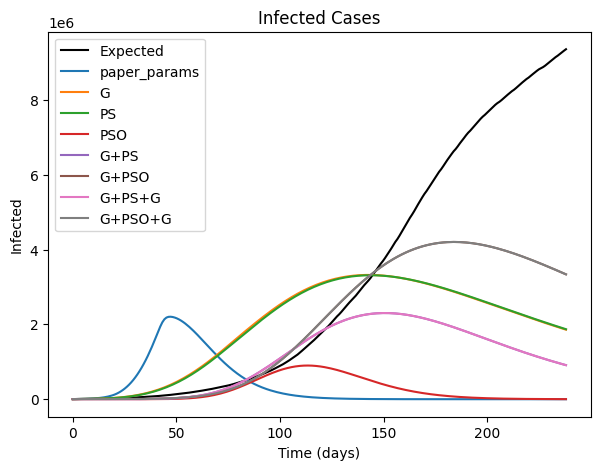

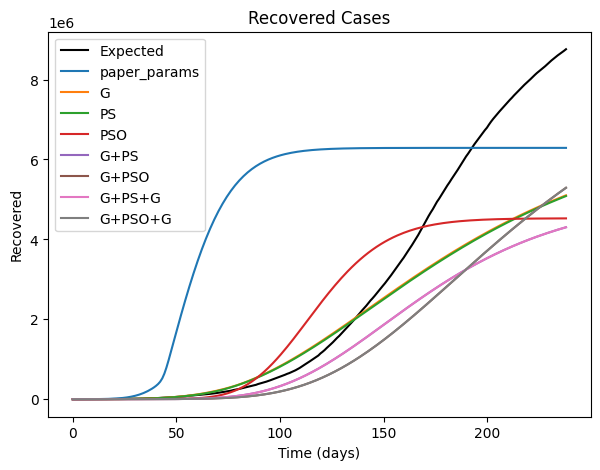

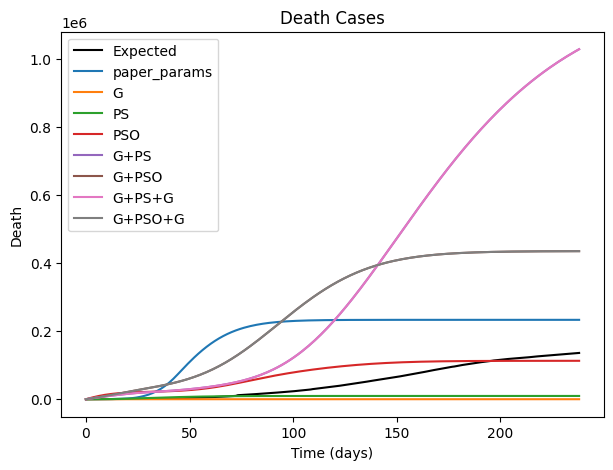

In [46]:
def plot_variable(results, variable, t, I0, R0, S0, N, t_lockdown):
    fig, ax = plt.subplots(figsize=(7, 5))
    # Plotting expected data
    if variable == 'Infected':
        ax.plot(t, I_exp, label='Expected', color='black')
    elif variable == 'Recovered':
        ax.plot(t, R_exp, label='Expected', color='black')
    elif variable == 'Death':
        ax.plot(t, D_exp, label='Expected', color='black')
    # Plotting the results
    for method, result in results.items():
        t, S, I, R, D = sird_sol(result, t, I0, R0, S0, N, t_lockdown)
        n = S + I + R + D
        if variable == 'Infected':
            plt.plot(t, I, label=method)
        elif variable == 'Recovered':
            plt.plot(t, R, label=method)
        elif variable == 'Death':
            plt.plot(t, D, label=method)

    plt.xlabel('Time (days)')
    plt.ylabel(variable)
    plt.title(f'{variable} Cases')
    plt.legend()
    plt.show()

# Define the results dictionary
results = {
    'paper_params':[0.202, 60.34, 0.0229, 0.0647, 43.63, 3.17e-3, 7.2e-4,  67.39],
    'G': result_G,
    'PS': result_PS,
    'PSO': result_pso,
    'G+PS': Result_G_PS,
    'G+PSO': result_G_PSO,
    'G+PS+G': Result_G_PS_G,
    'G+PSO+G': result_G_PSO_G
}

# Call the function for 'Infected', 'Recovered', and 'Death'
plot_variable(results, 'Infected', t, I0, R0, S0, N, t_lockdown)
plot_variable(results, 'Recovered', t, I0, R0, S0, N, t_lockdown)
plot_variable(results, 'Death', t, I0, R0, S0, N, t_lockdown)

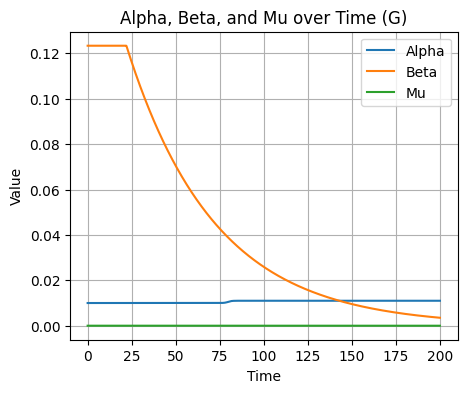

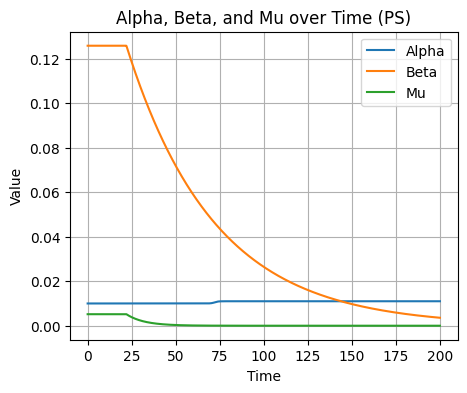

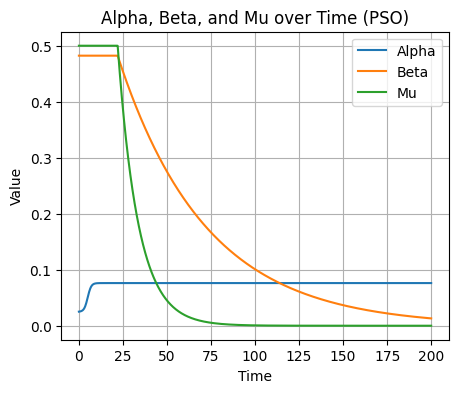

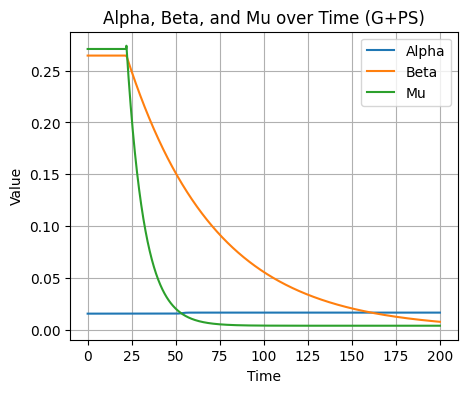

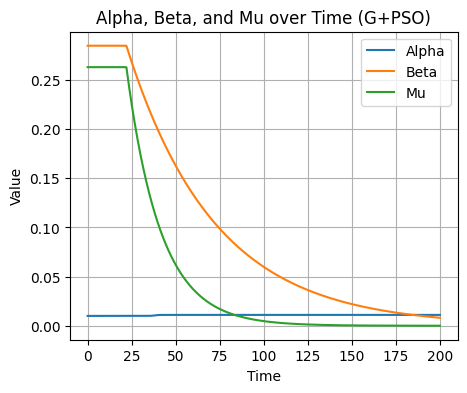

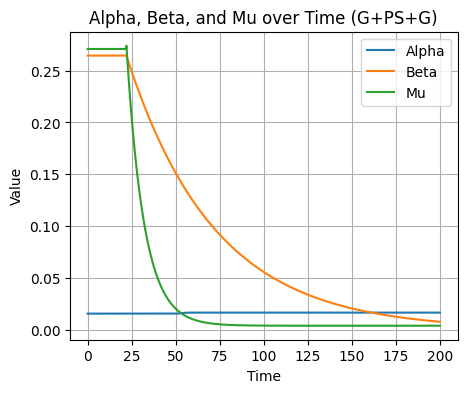

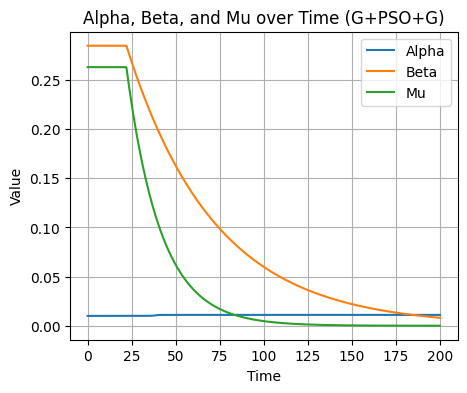

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate alpha, beta, and mu at each time point
def calculate_parameters(t_values, beta_0, beta_tau, alpha_0, alpha_1, alpha_tau, mu_0, mu_1, mu_tau, t_lockdown):
    alpha_values = []
    beta_values = []
    mu_values = []
    R_values = []
    for t in t_values:
        if t < t_lockdown:
            beta = beta_0  
            mu = mu_0
        else:
            beta = beta_0*((np.exp(-(t-t_lockdown)/beta_tau))**2)
            mu = mu_1 + mu_0*(np.exp(-(t-t_lockdown)/mu_tau))
        alpha = alpha_0 + (alpha_1/(1 + np.exp(-(t - alpha_tau))))
        alpha_values.append(alpha)
        beta_values.append(beta)
        mu_values.append(mu)
        R_values.append(beta/alpha+mu)
    return alpha_values, beta_values, mu_values

# Define parameters
t_lockdown = 22  
N = 1.38e9  

# Load optimization results from DataFrame
parameters = ['beta_0', 'tau_beta', 'alpha_0', 'alpha_1', 'alpha_tau', 'mu_0', 'mu_1', 'mu_tau']
optimization_results = {
    'G': df.loc['beta_0':'mu_tau', 'G'].values,
    'PS': df.loc['beta_0':'mu_tau', 'PS'].values,
    'PSO': df.loc['beta_0':'mu_tau', 'PSO'].values,
    'G+PS': df.loc['beta_0':'mu_tau', 'G+PS'].values,
    'G+PSO': df.loc['beta_0':'mu_tau', 'G+PSO'].values,
    'G+PS+G': df.loc['beta_0':'mu_tau', 'G+PS+G'].values,
    'G+PSO+G': df.loc['beta_0':'mu_tau', 'G+PSO+G'].values
}

# Define time range
t_values = np.linspace(0, 200, 1000)  # Adjust time range as needed

# Plotting
for method, results in optimization_results.items():
    plt.figure(figsize=(5, 4))
    alpha_values, beta_values, mu_values = calculate_parameters(t_values, *results, t_lockdown)
    plt.plot(t_values, alpha_values, label='Alpha')
    plt.plot(t_values, beta_values, label='Beta')
    plt.plot(t_values, mu_values, label='Mu')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Alpha, Beta, and Mu over Time ({method})')
    plt.legend()
    plt.grid(True)
    plt.show()


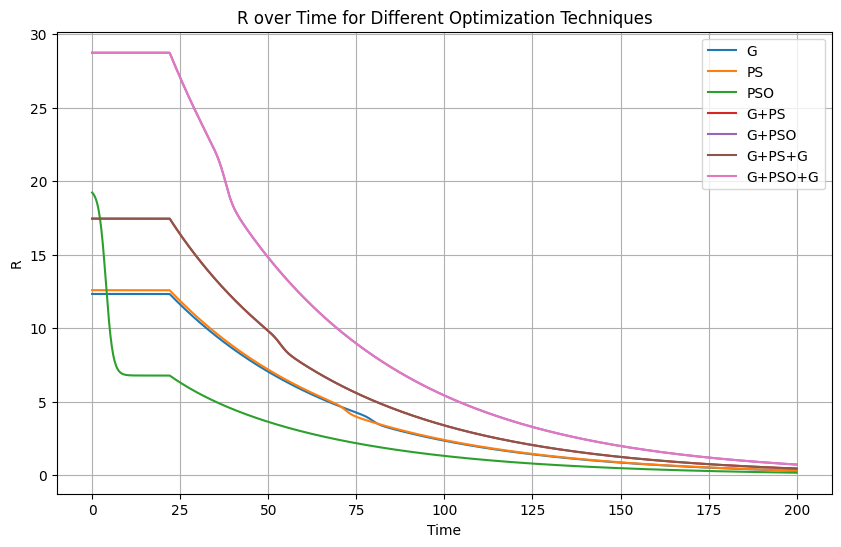

In [48]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate alpha, beta, and mu at each time point
def calculate_parameters(t_values, beta_0, beta_tau, alpha_0, alpha_1, alpha_tau, mu_0, mu_1, mu_tau, t_lockdown):
    R_values = []
    for t in t_values:
        if t < t_lockdown:
            beta = beta_0  
            mu = mu_0
        else:
            beta = beta_0*((np.exp(-(t-t_lockdown)/beta_tau))**2)
            mu = mu_1 + mu_0*(np.exp(-(t-t_lockdown)/mu_tau))
        alpha = alpha_0 + (alpha_1/(1 + np.exp(-(t - alpha_tau))))
        R_values.append(beta/alpha + mu)
    return R_values

# Define parameters
t_lockdown = 22  
N = 1.38e9 

# Load optimization results from DataFrame
parameters = ['beta_0', 'tau_beta', 'alpha_0', 'alpha_1', 'alpha_tau', 'mu_0', 'mu_1', 'mu_tau']
optimization_results = {
    'G': df.loc['beta_0':'mu_tau', 'G'].values,
    'PS': df.loc['beta_0':'mu_tau', 'PS'].values,
    'PSO': df.loc['beta_0':'mu_tau', 'PSO'].values,
    'G+PS': df.loc['beta_0':'mu_tau', 'G+PS'].values,
    'G+PSO': df.loc['beta_0':'mu_tau', 'G+PSO'].values,
    'G+PS+G': df.loc['beta_0':'mu_tau', 'G+PS+G'].values,
    'G+PSO+G': df.loc['beta_0':'mu_tau', 'G+PSO+G'].values
}

# Define time range
t_values = np.linspace(0, 200, 1000)  

# Plotting
plt.figure(figsize=(10, 6))
for method, results in optimization_results.items():
    R_values = calculate_parameters(t_values, *results, t_lockdown)
    plt.plot(t_values, R_values, label=method)

plt.xlabel('Time')
plt.ylabel('R')
plt.title('R over Time for Different Optimization Techniques')
plt.legend()
plt.grid(True)
plt.show()
